In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from epilepsy2bids.bids.chbmit.convert2bids import convert
import pandas as pd
from epilepsy2bids.eeg import Eeg
from epilepsy2bids.annotations import Annotations
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

In [3]:
# convert('/users/wojemann/local_data/CHBMIT','/users/wojemann/local_data/CHBMIT_BIDS')

In [4]:
subj = 5
run = 3

In [5]:
eeg = Eeg.loadEdfAutoDetectMontage(edfFile=f'/Users/wojemann/local_data/CHBMIT_BIDS/sub-{str(subj).zfill(2)}/ses-01/eeg/sub-{str(subj).zfill(2)}_ses-01_task-szMonitoring_run-{str(run).zfill(2)}_eeg.edf')
if eeg.montage is Eeg.Montage.UNIPOLAR:
    eeg.reReferenceToBipolar()
fs = eeg.fs

In [6]:
annot = Annotations.loadTsv(f'/Users/wojemann/local_data/CHBMIT_BIDS/sub-{str(subj).zfill(2)}/ses-01/eeg/sub-{str(subj).zfill(2)}_ses-01_task-szMonitoring_run-{str(run).zfill(2)}_events.tsv')

In [1055]:
signal_df = pd.DataFrame(eeg.data.T,columns=eeg.channels)

In [7]:
import scipy as sc
import numpy as np
import os
import sys
sys.path.append('../')
from DSOSD.utils import notch_filter, bandpass_filter, downsample
from DSOSD.model import NDD
# preprocess

In [1057]:
signal_filt = bandpass_filter(notch_filter(signal_df,fs,axis=0),fs,lo=3,hi=55,axis=0)

In [1058]:
signal_ds,fs = downsample(signal_filt,fs,128)

In [1059]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(12,4))
# onset_idx = int(1427*fs)
# offset_idx = int((1467+27+40)*fs)
# plt.plot(signal_ds[onset_idx:offset_idx,0])
# plt.plot(annot.getMask(fs)[onset_idx:offset_idx]*400)

In [1060]:
signal_ds_df = pd.DataFrame(signal_ds,columns=eeg.channels)

In [1061]:
mdl = NDD(fs=128)
mdl.fit(signal_ds_df.iloc[:30*fs,:])

In [1062]:
sz_prob = mdl(signal_ds_df)

In [1063]:
mdl.get_cval_threshold()

1.5273698264352469

In [1064]:
_,sz_clf = mdl.get_onset_and_spread(sz_prob,
                                    rwin_size=15,
                                    rwin_req=14,
                                    ret_smooth_mat=True,
                                    )

In [1065]:
dynasd_mask_wins = sz_clf.sum(axis=1) > 6

In [1066]:
window_start_times = mdl.get_win_times(signal_ds_df.count().median().astype(int))
# Convert window start times to sample indices
start_sample_indices = (window_start_times * fs).astype(int)
end_sample_indices = ((window_start_times + 1) * fs).astype(int)

# Implement forward filling in window space
dynasd_mask_wins_ff = dynasd_mask_wins.copy()

# Ensure a classification is valid if at least `rwin_req_idx` out of `rwin_size_idx` future windows are true
for j in range(len(dynasd_mask_wins) - mdl.rwin_size_idx):
    if dynasd_mask_wins[j]:  # If window j is classified as true
        future_sum = np.sum(dynasd_mask_wins[j:j + mdl.rwin_size_idx])  # Count future true windows
        if future_sum >= mdl.rwin_req_idx:  # If requirement met, propagate forward
            dynasd_mask_wins_ff[j:j + mdl.rwin_size_idx] = True


# Initialize a sample-level seizure array (assume total duration is max end time)
sample_length = end_sample_indices[-1]  # Assuming last window extends to end
dynasd_mask = np.zeros(sample_length, dtype=bool)

# Map window classification to sample space
for start, end, is_seizing in zip(start_sample_indices, end_sample_indices, dynasd_mask_wins_ff):
    if is_seizing:  # Only mark if the window was classified as seizing
        dynasd_mask[start:end] = True


In [1067]:
mask_true = annot.getMask(fs)

In [8]:
from timescoring.annotations import Annotation
from timescoring import scoring

In [1069]:
hyp = Annotation(dynasd_mask,fs)
ref = Annotation(mask_true,fs)
param = scoring.EventScoring.Parameters(
    toleranceStart=30,
    toleranceEnd=60,
    minOverlap=0,
    maxEventDuration=5 * 60,
    minDurationBetweenEvents=90)
scores = scoring.EventScoring(ref, hyp, param)

# Event scoring
- Sensitivity : 1.00 
- Precision   : 1.00 
- F1-score    : 1.00 
- FP/24h      : 0.00 



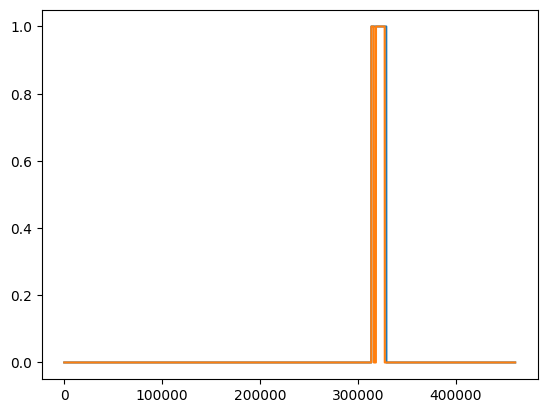

In [1070]:
print("# Event scoring\n" +
      "- Sensitivity : {:.2f} \n".format(scores.sensitivity) +
      "- Precision   : {:.2f} \n".format(scores.precision) +
      "- F1-score    : {:.2f} \n".format(scores.f1) +
      "- FP/24h      : {:.2f} \n".format(scores.fpRate))
plt.plot(mask_true)
plt.plot(dynasd_mask)

In [29]:
results = pd.read_pickle('cval_results_df.pkl')
results['smoothing'] = results['smoothing'].astype(str)
# results = results[results.patient != 'sub-04']

In [30]:
results.head()


,patient,run,threshold,low_pass,high_pass,training,smoothing,spatial_threshold,sensitivity,precision,F1,fprate
0,sub-01,run-06,cval,1,55,10,"(4, 5)",4,1.0,0.5,0.666667,37.16129
1,sub-01,run-06,cval,1,55,10,"(4, 5)",6,1.0,1.0,1.000000,0.00000
2,sub-01,run-06,cval,1,55,10,"(4, 5)",9,1.0,1.0,1.000000,0.00000
3,sub-01,run-06,cval,1,55,10,"(9, 10)",4,1.0,1.0,1.000000,0.00000
4,sub-01,run-06,cval,1,55,10,"(9, 10)",6,1.0,1.0,1.000000,0.00000


In [39]:
results_mean = results.groupby(['threshold','low_pass','high_pass','training','smoothing','spatial_threshold'])[['sensitivity','precision','F1','fprate']].mean()
# results_mean['smoothing'] = results_mean['smoothing'].astype(str)

In [40]:
results_mean['F1'].idxmax()

('cval', 1, 100, 60, '(14, 15)', 9)

In [41]:
results_mean.loc[('cval', 1, 100, 60, '(14, 15)', 9)]

sensitivity     0.958333
precision       0.781382
F1              0.822720
fprate         20.687919
Name: (cval, 1, 100, 60, (14, 15), 9), dtype: float64

<Axes: xlabel='training', ylabel='F1'>

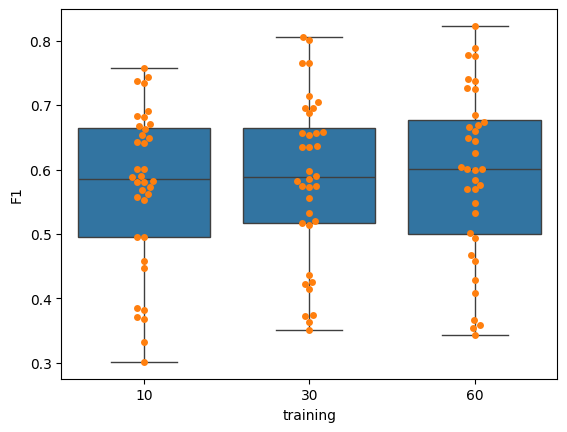

In [42]:
x = 'training'
y = 'F1'
sns.boxplot(results_mean,x=x,y=y)
sns.swarmplot(results_mean,x=x,y=y)

<Axes: xlabel='spatial_threshold', ylabel='smoothing'>

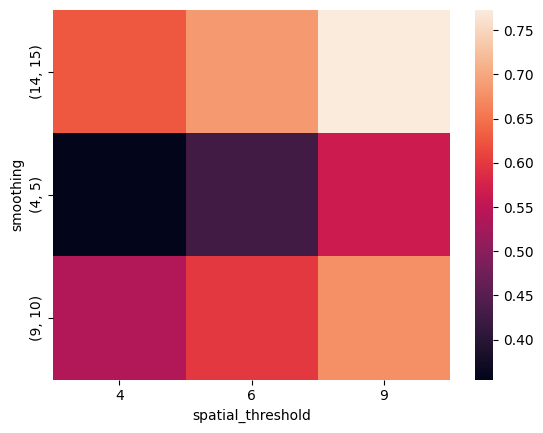

In [43]:
results_heat = results.groupby(['smoothing','spatial_threshold'])[['sensitivity','precision','F1','fprate']].mean()

glue = results_heat.reset_index().pivot(index="smoothing", columns="spatial_threshold", values="F1")
sns.heatmap(glue)